In [59]:
import numpy as np
import matplotlib.pyplot as plt
import math

def compute_limit(obs_counts, sm_counts, bsm_probs,
                  N_had, BR_Zbb=0.151,
                  BR_scan=np.logspace(-6, -3, 200),
                  CL=0.90, ymin=0.0, ymax=10.0, title=r"$B_d \rightarrow \rho a$"):
    """
    Poisson-likelihood χ² scan vs BR(Bd->rho a), anchored at the best fit (>=0).
    Uses ABSOLUTE per-Bd selection probabilities:
      bsm_probs[i] = selected_counts_in_bin_i / 490_249   (for BR=1)
    DO NOT normalize bsm_probs to sum 1.

    Expected per-bin counts:
      mu_i(BR) = sm_counts[i] + (N_had * BR_Zbb * 2) * BR * bsm_probs[i]
    """

    obs_counts = np.asarray(obs_counts, dtype=float)
    sm_counts  = np.asarray(sm_counts,  dtype=float)
    bsm_probs  = np.asarray(bsm_probs,  dtype=float)
    assert obs_counts.shape == sm_counts.shape == bsm_probs.shape, "bin arrays must match"

    # Quick sanity: overall selected-signal efficiency (should be < 1)
    eps_sel = float(np.sum(bsm_probs))
    if eps_sel <= 0:
        raise ValueError("bsm_probs sum is zero: need non-empty BSM template.")
    # print(f"[info] total selected-signal efficiency at BR=1: eps_sel = {eps_sel:.3e}")

    # Critical value for 1 d.o.f.
    crit_map = {0.90: 2.71, 0.95: 3.84, 0.68: 1.00}
    target = crit_map.get(CL, 2.71)

    # Number of produced b-hadrons in the data exposure
    N_b = N_had * BR_Zbb * 2.0

    def log_poisson_ll(n, mu):
        mu = np.clip(mu, 1e-300, None)  # avoid log(0)
        return np.sum(n * np.log(mu) - mu - [math.lgamma(int(x)+1) for x in n])

    # Include BR=0 so best fit can be exactly background-only
    BR_grid = np.concatenate(([0.0], BR_scan))

    # Profile (1D) over BR on the grid
    logL_vals = []
    for BR in BR_grid:
        mu = sm_counts + (N_b * BR) * bsm_probs
        logL_vals.append(log_poisson_ll(obs_counts, mu))
    logL_vals = np.array(logL_vals)

    # Best-fit point (bounded by the grid, BR >= 0)
    i_hat = int(np.argmax(logL_vals))
    BR_hat = float(BR_grid[i_hat])
    logL_hat = float(logL_vals[i_hat])

    # Non-negative chi2 curve
    chi2_vals = 2.0 * (logL_hat - logL_vals)

    # One-sided UL: first crossing for BR >= BR_hat
    BR_plot  = BR_grid[1:]
    chi2_plot = chi2_vals[1:]
    mask = BR_plot >= BR_hat
    idx = np.where(mask & (chi2_plot >= target))[0]

    limit = None
    if idx.size:
        i = idx[0]
        if i > 0:
            # Interpolate in log(BR) for stability
            x0, x1 = np.log(BR_plot[i-1]), np.log(BR_plot[i])
            y0, y1 = chi2_plot[i-1], chi2_plot[i]
            t = (target - y0) / (y1 - y0)
            limit = float(np.exp(x0 + t * (x1 - x0)))
        else:
            limit = float(BR_plot[i])

    # Plot
    plt.figure(figsize=(8,6))
    plt.plot(BR_plot, chi2_plot, label=r"$-2\,\Delta\ln\mathcal{L}$")
    plt.axhline(target, color='r', ls='--', label=f"{int(CL*100)}% CL (χ²={target:.2f})")
    if limit is not None:
        plt.axvline(limit, color='g', ls=':', label=f"Limit ≈ {limit:.2e}")
    plt.xscale("log")
    plt.ylim(ymin, ymax)
    plt.xlabel(r"$\mathrm{BR}(B_d \to \rho a)$", fontsize=16)
    plt.ylabel(r"$\chi^2 = -2\,\Delta\ln\mathcal{L}$", fontsize=16)
    plt.title(title, fontsize=19)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig("BR.png")
    plt.show()

    if limit is not None:
        print(f"{int(CL*100)}% CL upper limit on BR(Bd -> rho a): {limit:.3e}")
    else:
        print(f"No crossing with the {int(CL*100)}% CL line found.")

    return BR_plot, chi2_plot, limit


In [60]:
obs_counts = [420, 113, 31, 1, 1]   # ALEPH observed per bin (exclusive)
sm_counts  = [839, 245, 51, 12, 0]   # SM expectations
bsm_probs  = [0.022105, 0.018305, 0.012985, 0.004987, 0.000447] # probabilities from BSM injection 
N_had = 4_176_778  # number of hadronic events


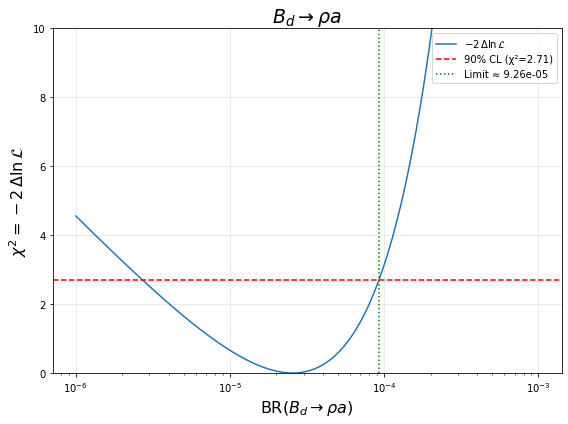

90% CL upper limit on BR(Bd -> rho a): 9.260e-05


In [61]:
BR_scan, chi2, limit = compute_limit(obs_counts, sm_counts, bsm_probs, N_had)


In [69]:
import numpy as np
import matplotlib.pyplot as plt
import math

def compute_limit_with_asimov_bands(
    obs_counts, sm_counts, bsm_probs,
    N_had, BR_Zbb=0.151,
    BR_scan=np.logspace(-6, -3, 300),
    CL=0.90, ymin=0.0, ymax=10.0, title=r"$B_d \rightarrow \rho a$"
):
    """
    Poisson-likelihood chi^2 scan vs BR(Bd->rho a), anchored at the best fit (>=0),
    with Asimov (expected) curve and ±1σ/±2σ expected bands.

    Uses ABSOLUTE per-Bd selection probabilities:
      bsm_probs[i] = selected_counts_in_bin_i / 490_249  (for BR=1)
    Do NOT normalize bsm_probs to sum=1.

    Expected per-bin counts:
      mu_i(BR) = sm_counts[i] + (N_had * BR_Zbb * 2) * BR * bsm_probs[i]
    """
    # --- inputs ---
    obs_counts = np.asarray(obs_counts, dtype=float)
    sm_counts  = np.asarray(sm_counts,  dtype=float)
    bsm_probs  = np.asarray(bsm_probs,  dtype=float)
    assert obs_counts.shape == sm_counts.shape == bsm_probs.shape, "bin arrays must match"
    if np.any(sm_counts < 0) or np.any(bsm_probs < 0):
        raise ValueError("sm_counts and bsm_probs must be non-negative.")
    if np.sum(bsm_probs) <= 0:
        raise ValueError("bsm_probs sum is zero: empty BSM template.")

    # --- constants and helpers ---
    target = {0.90: 2.71, 0.95: 3.84, 0.68: 1.00}.get(CL, 2.71)
    Zthr = np.sqrt(target)               # e.g. sqrt(2.71)=1.646 for 90% CL
    N_b = N_had * BR_Zbb * 2.0          # produced b-hadrons in exposure

    def logpois(n, mu):
        mu = np.clip(mu, 1e-300, None)
        return np.sum(n * np.log(mu) - mu - [math.lgamma(int(x)+1) for x in n])

    # include BR=0 so best fit can be exactly at 0
    BR_grid = np.concatenate(([0.0], BR_scan))

    # --- observed curve ---
    logL_obs = []
    for BR in BR_grid:
        mu = sm_counts + (N_b * BR) * bsm_probs
        logL_obs.append(logpois(obs_counts, mu))
    logL_obs = np.array(logL_obs)
    ihat_obs = int(np.argmax(logL_obs))
    BRhat_obs = float(BR_grid[ihat_obs])
    chi2_obs = 2.0 * (logL_obs[ihat_obs] - logL_obs)    # >= 0

    # observed UL
    BR_plot = BR_grid[1:]
    chi2_plot_obs = chi2_obs[1:]
    mask_obs = BR_plot >= BRhat_obs
    idx_obs = np.where(mask_obs & (chi2_plot_obs >= target))[0]
    UL_obs = None
    if idx_obs.size:
        i = idx_obs[0]
        if i > 0:
            x0, x1 = np.log(BR_plot[i-1]), np.log(BR_plot[i])
            y0, y1 = chi2_plot_obs[i-1], chi2_plot_obs[i]
            t = (target - y0) / (y1 - y0)
            UL_obs = float(np.exp(x0 + t * (x1 - x0)))
        else:
            UL_obs = float(BR_plot[i])

    # --- Asimov (expected) curve: set obs := sm_counts ---
    logL_A = []
    for BR in BR_grid:
        mu = sm_counts + (N_b * BR) * bsm_probs
        logL_A.append(logpois(sm_counts, mu))
    logL_A = np.array(logL_A)
    ihat_A = int(np.argmax(logL_A))           # typically at BR=0
    BRhat_A = float(BR_grid[ihat_A])
    chi2_A = 2.0 * (logL_A[ihat_A] - logL_A)

    BR_plot_A = BR_grid[1:]
    chi2_plot_A = chi2_A[1:]
    mask_A = BR_plot_A >= BRhat_A
    idx_A = np.where(mask_A & (chi2_plot_A >= target))[0]
    UL_exp = None
    if idx_A.size:
        i = idx_A[0]
        if i > 0:
            x0, x1 = np.log(BR_plot_A[i-1]), np.log(BR_plot_A[i])
            y0, y1 = chi2_plot_A[i-1], chi2_plot_A[i]
            t = (target - y0) / (y1 - y0)
            UL_exp = float(np.exp(x0 + t * (x1 - x0)))
        else:
            UL_exp = float(BR_plot_A[i])

    # --- expected bands from asymptotics (Cowan et al.): 
    # UL_exp = σ_eff * Zthr  ->  σ_eff = UL_exp / Zthr
    bands = {}
    if UL_exp is not None and UL_exp > 0:
        sigma_eff = UL_exp / Zthr
        # endpoints: μ_{±1σ} = σ_eff * (Zthr ± 1),  μ_{±2σ} = σ_eff * (Zthr ± 2)
        m1_lo = sigma_eff * (Zthr - 1.0)
        m1_hi = sigma_eff * (Zthr + 1.0)
        m2_lo = sigma_eff * (Zthr - 2.0)
        m2_hi = sigma_eff * (Zthr + 2.0)
        # clip lower edges to plotting minimum (log axis cannot show 0)
        xmin = BR_plot[0]
        bands["1sigma"] = (max(m1_lo, xmin), m1_hi)
        bands["2sigma"] = (max(m2_lo, xmin), m2_hi)

    # --- plot ---
    fig, ax = plt.subplots(figsize=(8,6))

    # expected bands first (background shading)
    if "1sigma" in bands:
        ax.axvspan(bands["1sigma"][0], bands["1sigma"][1],
                   color="limegreen", alpha=0.35, label="Expected ±1σ")

    # curves
    ax.plot(BR_plot,   chi2_plot_obs, label=r"Observed: $-2\,\Delta\ln\mathcal{L}$")
    ax.plot(BR_plot_A, chi2_plot_A,   ls='--', label="Asimov expected")

    # thresholds and ULs
    ax.axhline(target, color='r', ls='--', label=f"{int(CL*100)}% CL (χ²={target:.2f})")
    if UL_obs is not None:
        ax.axvline(UL_obs, color='g', ls=':', label=f"Obs. UL ≈ {UL_obs:.2e}")
    if UL_exp is not None:
        ax.axvline(UL_exp, color='k', ls=':', label=f"Exp. UL ≈ {UL_exp:.2e}")

    # best-fit marker
    ax.scatter([BRhat_obs if BRhat_obs>0 else BR_plot[0]], [0.0],
               color='k', s=25, zorder=3, label=fr"Best fit $\hat{{\mu}}$={BRhat_obs:.2e}")

    ax.set_xscale("log")
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel(r"$\mathrm{BR}(B_d \to \rho a)$", fontsize=16)
    ax.set_ylabel(r"$\chi^2 = -2\,\Delta\ln\mathcal{L}$", fontsize=16)
    ax.set_title(title, fontsize=19)
    ax.grid(True, alpha=0.3)
    ax.legend()
    fig.tight_layout()
    plt.savefig("BR_with_bands.png")
    plt.show()

    print(f"Observed {int(CL*100)}% CL UL:   {None if UL_obs is None else f'{UL_obs:.3e}'}")
    print(f"Expected {int(CL*100)}% CL UL:   {None if UL_exp is None else f'{UL_exp:.3e}'}")
    if "1sigma" in bands:
        lo, hi = bands["1sigma"]; print(f"Expected ±1σ band: [{lo:.3e}, {hi:.3e}]")
    if "2sigma" in bands:
        lo, hi = bands["2sigma"]; print(f"Expected ±2σ band: [{lo:.3e}, {hi:.3e}]")

    return BR_plot, chi2_plot_obs, UL_obs, UL_exp, bands



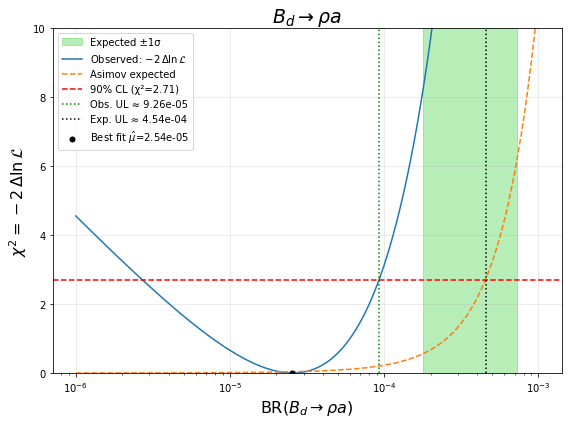

Observed 90% CL UL:   9.262e-05
Expected 90% CL UL:   4.535e-04
Expected ±1σ band: [1.780e-04, 7.291e-04]
Expected ±2σ band: [1.000e-06, 1.005e-03]


In [70]:
obs_counts = [420, 113, 31, 1, 1]
sm_counts  = [839, 245, 51, 12, 0]
bsm_probs  = [0.022105, 0.018305, 0.012985, 0.004987, 0.000447]
N_had = 4_176_778

BRs, chi2_obs, UL_obs, UL_exp, bands = compute_limit_with_asimov_bands(
    obs_counts, sm_counts, bsm_probs, N_had,
    BR_Zbb=0.151, CL=0.90, ymin=0.0, ymax=10.0
)


In [78]:
import numpy as np
import matplotlib.pyplot as plt
import math

def compute_limit_with_toy_bands(
    obs_counts, sm_counts, bsm_probs,
    N_had, BR_Zbb=0.151,
    BR_scan=np.logspace(-6, -3, 300),
    CL=0.90, Ntoys=3000, seed=12345,
    ymin=0.0, ymax=10.0,
    title=r"$B_d \rightarrow \rho a$",
    savefig="BR_toy_bands.png",
    cap_at_max=True  # if a toy has no crossing, set UL to max(BR_scan)
):
    """
    Toy-based expected bands for the BR upper limit.
    - Likelihood: Poisson per bin.
    - χ²(BR) = 2 [lnL(BR_hat) - lnL(BR)]  (best-fit anchored, ≥0).
    - Signal model: ABSOLUTE per-Bd selection probabilities (counts/490249).
      Do NOT normalize bsm_probs; we use them as-is.
    - Expected (toy) bands: draw Poisson toys from sm_counts (background-only),
      compute the UL for each, then take median (50%), ±1σ (16,84%), ±2σ (2.5,97.5%).

    Returns
    -------
    dict with observed UL, toy median UL, 1σ/2σ band edges, toy UL samples, etc.
    """

    # --- inputs ---
    obs_counts = np.asarray(obs_counts, dtype=float)
    sm_counts  = np.asarray(sm_counts,  dtype=float)
    bsm_probs  = np.asarray(bsm_probs,  dtype=float)
    assert obs_counts.shape == sm_counts.shape == bsm_probs.shape, "bin arrays must match"
    if np.any(sm_counts < 0) or np.any(bsm_probs < 0):
        raise ValueError("sm_counts and bsm_probs must be non-negative.")
    if np.sum(bsm_probs) <= 0:
        raise ValueError("bsm_probs sum is zero: empty BSM template.")

    # --- constants ---
    target = {0.90: 2.71, 0.95: 3.84, 0.68: 1.00}.get(CL, 2.71)
    N_b = N_had * BR_Zbb * 2.0  # produced b-hadrons in exposure

    # include BR=0 so best fit can be at 0
    BR_grid = np.concatenate(([0.0], BR_scan))
    BR_min_plot = BR_scan[0]

    # helpers
    def logpois(n, mu):
        mu = np.clip(mu, 1e-300, None)
        # factorial term cancels in differences but we keep it (safe for small n)
        return np.sum(n * np.log(mu) - mu - [math.lgamma(int(x)+1) for x in n])

    sig_unit = N_b * bsm_probs  # per unit BR

    def profile_curve_and_ul(nvec):
        # build logL(BR) on the grid
        logL = []
        for BR in BR_grid:
            mu = sm_counts + BR * sig_unit
            logL.append(logpois(nvec, mu))
        logL = np.array(logL)

        i_hat = int(np.argmax(logL))
        BR_hat = float(BR_grid[i_hat])
        chi2 = 2.0 * (logL[i_hat] - logL)  # ≥ 0

        # one-sided UL: first crossing for BR >= BR_hat (ignore BR=0 in plotting)
        BR_plot = BR_grid[1:]
        chi2_plot = chi2[1:]
        mask = BR_plot >= BR_hat
        idx = np.where(mask & (chi2_plot >= target))[0]
        UL = None
        if idx.size:
            i = idx[0]
            if i > 0:
                # interpolate in log BR
                x0, x1 = np.log(BR_plot[i-1]), np.log(BR_plot[i])
                y0, y1 = chi2_plot[i-1], chi2_plot[i]
                t = (target - y0) / (y1 - y0)
                UL = float(np.exp(x0 + t * (x1 - x0)))
            else:
                UL = float(BR_plot[i])
        elif cap_at_max:
            UL = float(BR_plot[-1])

        return BR_plot, chi2_plot, UL, BR_hat

    # --- observed curve & UL ---
    BR_plot, chi2_obs, UL_obs, BRhat_obs = profile_curve_and_ul(obs_counts)

    # --- Asimov curve (optional, dashed in plot) ---
    BR_plot_A, chi2_A, UL_Asimov, BRhat_A = profile_curve_and_ul(sm_counts)

    # --- toys (background-only) ---
    rng = np.random.default_rng(seed)
    UL_toys = np.empty(Ntoys, dtype=float)
    saturated = 0
    for t in range(Ntoys):
        toy = rng.poisson(lam=sm_counts)
        _, _, UL_t, _ = profile_curve_and_ul(toy)
        if UL_t is None:
            saturated += 1
            UL_t = BR_plot[-1] if cap_at_max else np.nan
        UL_toys[t] = UL_t

    # quantiles for expected bands
    q2p5, q16, q50, q84, q97p5 = np.nanpercentile(UL_toys, [2.5, 16, 50, 84, 97.5])
    # clip left edges at BR_min_plot for log axis
    q2p5_clip = max(q2p5, BR_min_plot)
    q16_clip  = max(q16,  BR_min_plot)

    # --- plot ---
    fig, ax = plt.subplots(figsize=(8,6))

    # expected bands (from toys)
    ax.axvspan(q2p5_clip, q97p5, color="gold", alpha=0.35, label="Expected ±2σ")
    ax.axvspan(q16_clip,  q84,   color="limegreen", alpha=0.35, label="Expected ±1σ")

    # curves
    ax.plot(BR_plot,   chi2_obs, label=r"Observed: $-2\,\Delta\ln\mathcal{L}$")
    ax.plot(BR_plot_A, chi2_A,   ls='--', label="Asimov expected")

    # thresholds & ULs
    ax.axhline(target, color='r', ls='--', label=f"{int(CL*100)}% CL (χ²={target:.2f})")
    ax.axvline(q50,    color='k', ls=':', label=f"Exp. UL ≈ {q50:.2e}")
    if UL_obs is not None:
        ax.axvline(UL_obs, color='g', ls=':', label=f"Obs. UL ≈ {UL_obs:.2e}")

    # best fit marker
    ax.scatter([BRhat_obs if BRhat_obs>0 else BR_plot[0]], [0.0],
               color='k', s=25, zorder=3, label=fr"Best fit $\hat{{\mu}}$={BRhat_obs:.2e}")

    ax.set_xscale("log")
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel(r"$\mathrm{BR}(B_d \to \rho a)$", fontsize=16)
    ax.set_ylabel(r"$\chi^2 = -2\,\Delta\ln\mathcal{L}$", fontsize=16)
    ax.set_title(title, fontsize=19)
    ax.grid(True, alpha=0.3)
    ax.legend()
    fig.tight_layout()
    fig.savefig(savefig)
    plt.show()

    print(f"Observed {int(CL*100)}% CL UL: {None if UL_obs is None else f'{UL_obs:.3e}'}")
    print(f"Expected {int(CL*100)}% CL UL (toy median): {q50:.3e}")
    print(f"Expected ±1σ (toys): [{q16:.3e}, {q84:.3e}]")
    print(f"Expected ±2σ (toys): [{q2p5:.3e}, {q97p5:.3e}]")
    if cap_at_max:
        print(f"Saturated toys at grid max: {saturated}/{Ntoys} "
              f"({100.0*saturated/Ntoys:.1f}%)")

    return {
        "BR_plot": BR_plot,
        "chi2_obs": chi2_obs,
        "UL_obs": UL_obs,
        "UL_Asimov": UL_Asimov,
        "toy_ULs": UL_toys,
        "toy_expected_UL": q50,
        "toy_band_1sigma": (q16, q84),
        "toy_band_2sigma": (q2p5, q97p5),
        "saturated_fraction": saturated / Ntoys,
    }


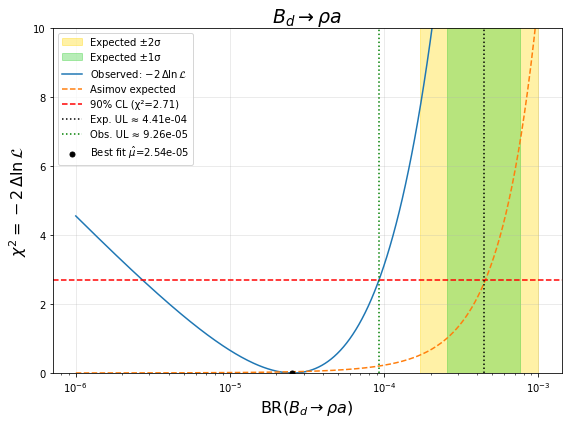

Observed 90% CL UL: 9.262e-05
Expected 90% CL UL (toy median): 4.411e-04
Expected ±1σ (toys): [2.550e-04, 7.563e-04]
Expected ±2σ (toys): [1.707e-04, 1.000e-03]
Saturated toys at grid max: 0/3000 (0.0%)


In [79]:
obs_counts = [420, 113, 31, 1, 1]
sm_counts  = [839, 245, 51, 12, 0]
bsm_probs  = [0.022105, 0.018305, 0.012985, 0.004987, 0.000447]
N_had = 4_176_778

out = compute_limit_with_toy_bands(
    obs_counts, sm_counts, bsm_probs, N_had,
    BR_Zbb=0.151, CL=0.90,
    Ntoys=3000, seed=12345,
    ymin=0.0, ymax=10.0,
    savefig="BR_toy_bands.png"
)
